In [36]:
import sys
import os
sys.path.append(os.path.abspath("../src"))
sys.path.append(os.path.abspath("../"))

In [37]:
import os
import numpy as np
from pathlib import Path
from tqdm import tqdm
from scipy import ndimage
from scipy.ndimage import uniform_filter, minimum_filter, maximum_filter
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
import joblib
import gc
from utils import load_and_normalize_tiff, load_mask
import json
import warnings
from rasterio.errors import NotGeoreferencedWarning
warnings.filterwarnings("ignore", category=NotGeoreferencedWarning)

class Config:
    SEED = 42
    PROCESSED_DATA = Path("../data/processed")
    OUTPUT_PATH = Path("../outputs")
    MODEL_PATH = OUTPUT_PATH / "models"
    FEATURE_SELECTOR_PATH = OUTPUT_PATH / "feature_selector"
    os.makedirs(MODEL_PATH, exist_ok=True)
    os.makedirs(FEATURE_SELECTOR_PATH, exist_ok=True)

    N_EPOCHS = 30
    VAL_SPLIT = 0.15
    TEST_SPLIT = 0.15
    FEATURE_SELECTION_SAMPLES = 100000
    
    SGD_PARAMS = {
        'loss': 'log_loss',
        'penalty': 'elasticnet',
        'alpha': 0.0005,
        'l1_ratio': 0.15,
        'learning_rate': 'adaptive',
        'eta0': 0.01,
        'max_iter': 1,
        # 'class_weight': 'balanced',
        'n_jobs': os.cpu_count()-1
    }
    
    POST_PROCESS = True
    DICE_THRESHOLD = 0.5
    EARLY_STOP_PATIENCE = 5
    EARLY_STOP_DELTA = 0.005

config = Config()

In [38]:
def calculate_class_weights(image_pairs):
    class_counts = {0: 0, 1: 0}
    for _, mask_path, _ in tqdm(image_pairs, desc='Calculating class weights'):
        mask = load_mask(mask_path)
        unique, counts = np.unique(mask, return_counts=True)
        for cls, cnt in zip(unique, counts):
            class_counts[cls] += cnt
    
    total = class_counts[0] + class_counts[1]
    return {
        0: total / (2 * class_counts[0]),
        1: total / (2 * class_counts[1])
    }

In [39]:
def calculate_texture_features(band, window_size):
    entropy = uniform_filter(band * np.log(band + 1e-10), size=window_size)
    mean = uniform_filter(band, size=window_size)
    variance = uniform_filter((band - mean)**2, size=window_size)
    min_val = minimum_filter(band, size=window_size)
    max_val = maximum_filter(band, size=window_size)
    homogeneity = 1.0 / ((max_val - min_val) + 1e-6)
    return np.stack([entropy, variance, homogeneity], axis=-1)

def calculate_spectral_indices(image):
    red, green, blue, nir = [np.nan_to_num(image[i], 0) for i in range(4)]
    eps = 1e-6
    return {
        'ndvi': (nir - red)/(nir + red + eps),
        'ndwi': (green - nir)/(green + nir + eps),
        'evi': 2.5*(nir - red)/(nir + 6*red - 7.5*blue + 1 + eps),
        'vari': (green - red)/(green + red - blue + eps)
    }

def calculate_spatial_features(band, window_size):
    mean = uniform_filter(band, window_size)
    mean_sq = uniform_filter(band**2, window_size)
    variance = np.maximum(mean_sq - mean**2, 0.0)
    std = np.sqrt(variance)
    min_val = minimum_filter(band, window_size)
    max_val = maximum_filter(band, window_size)
    return np.stack([mean, std, min_val, max_val, max_val-min_val], axis=-1)

def extract_features(image, feature_selector=None):
    indices = calculate_spectral_indices(image)
    features = []
    
    # Original bands
    for band in image:
        features.append(band.ravel())
    
    # Spectral indices
    for idx in indices.values():
        features.append(idx.ravel())
    
    # Spatial features
    for band in image:
        for ws in [3, 5]:
            spatial = calculate_spatial_features(band, ws)
            for i in range(spatial.shape[-1]):
                features.append(spatial[..., i].ravel())
    
    # Texture features
    for band in image:
        texture = calculate_texture_features(band, 5)
        for i in range(texture.shape[-1]):
            features.append(texture[..., i].ravel())
    
    features = np.stack(features, axis=1).astype('float32')
    features = np.nan_to_num(features, 0)
    
    if feature_selector:
        features = feature_selector.transform(features)
    
    return features

In [40]:
def train_feature_selector(train_pairs):
    X_sample, y_sample = [], []
    
    for img_path, mask_path, _ in tqdm(train_pairs[:100], desc="Feature selection sampling"):
        image = load_and_normalize_tiff(img_path)
        mask = load_mask(mask_path)
        features = extract_features(image)
        
        idx = np.random.choice(features.shape[0], config.FEATURE_SELECTION_SAMPLES//100, replace=False)
        X_sample.append(features[idx])
        y_sample.append(mask.ravel()[idx])
    
    X_sample = np.concatenate(X_sample)
    y_sample = np.concatenate(y_sample)
    
    print(f"Total features before selection: {X_sample.shape[1]}")
    
    rf = RandomForestClassifier(n_estimators=50, n_jobs=-1, class_weight='balanced')
    rf.fit(X_sample, y_sample)
    
    importances = rf.feature_importances_
    print(f"Feature importance range: {importances.min():.4f} - {importances.max():.4f}")
    
    selector = SelectFromModel(rf, prefit=True, threshold="median")
    X_selected = selector.transform(X_sample)
    
    print(f"Number of features selected: {X_selected.shape[1]}")
    print(f"Percentage kept: {X_selected.shape[1]/X_sample.shape[1]*100:.1f}%")
    
    selected_indices = selector.get_support(indices=True)
    print(f"Selected feature indices: {selected_indices}")
    
    print("\nSelected feature importances:")
    for idx in selected_indices:
        print(f"Feature {idx}: {importances[idx]:.4f}")
    
    joblib.dump(selector, config.FEATURE_SELECTOR_PATH / "feature_selector.joblib")
    
    return selector

In [ ]:
def calculate_dice(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection + 1e-7) / (np.sum(y_true) + np.sum(y_pred) + 1e-7)

def post_process_mask(mask):
    # Morphological cleanup
    mask = ndimage.binary_closing(mask, structure=np.ones((3,3)))
    
    # Remove small objects
    labels, counts = ndimage.label(mask)
    for i in range(1, counts+1):
        if np.sum(labels == i) < 50:
            mask[labels == i] = 0
    
    # Fill holes
    mask = ndimage.binary_fill_holes(mask)
    return mask

def train_model(train_pairs, val_pairs, feature_selector):
    class_weights = calculate_class_weights(train_pairs)
    model = SGDClassifier(**config.SGD_PARAMS,class_weight=class_weights)
    best_dice = 0
    no_improve = 0
    
    for epoch in range(config.N_EPOCHS):
        print(f"\nEpoch {epoch+1}/{config.N_EPOCHS}")
        
        # Training
        for img_path, mask_path, _ in tqdm(train_pairs, desc="Training"):
            image = load_and_normalize_tiff(img_path)
            mask = load_mask(mask_path)
            features = extract_features(image, feature_selector)
            model.partial_fit(features, mask.ravel(), classes=np.array([0, 1]))
            
        # Validation
        val_dices = []
        for img_path, mask_path, _ in tqdm(val_pairs, desc="Training"):
            image = load_and_normalize_tiff(img_path)
            mask = load_mask(mask_path)
            features = extract_features(image, feature_selector)
            proba = model.predict_proba(features)[:, 1]
            pred = (proba > config.DICE_THRESHOLD).astype(int)
            
            if config.POST_PROCESS:
                pred = post_process_mask(pred.reshape(mask.shape))
            
            val_dices.append(calculate_dice(mask.ravel(), pred.ravel()))
        
        mean_dice = np.mean(val_dices)
        print(f"Val Dice: {mean_dice:.4f} | Best: {best_dice:.4f}")
        
        # Early stopping
        if mean_dice > best_dice + config.EARLY_STOP_DELTA:
            best_dice = mean_dice
            no_improve = 0
            joblib.dump(model, config.MODEL_PATH / "best_model.joblib")
        else:
            no_improve += 1
            if no_improve >= config.EARLY_STOP_PATIENCE:
                print(f"Early stopping at epoch {epoch+1}")
                break
    
    return model

In [42]:
if __name__ == "__main__":
    # Load dataset with stratification
    image_pairs = []
    category_counts = {'cloud_free': 0, 'partially_clouded': 0, 'fully_clouded': 0}
    
    for category in ['cloud_free', 'partially_clouded', 'fully_clouded']:
        img_dir = config.PROCESSED_DATA / "data" / category
        mask_dir = config.PROCESSED_DATA / "masks" / category
        
        for img_file in img_dir.glob('*.tif'):
            mask_path = mask_dir / img_file.name
            if mask_path.exists():
                image_pairs.append((img_file, mask_path, category))
                category_counts[category] += 1
    
    # Print category distribution
    print("Original dataset distribution:")
    for cat, count in category_counts.items():
        print(f"{cat}: {count} images ({count/len(image_pairs)*100:.1f}%)")
    
    # Create stratification labels
    strat_labels = [cat for (_, _, cat) in image_pairs]
    
    # Stratified split with random state for reproducibility
    train_pairs, test_pairs = train_test_split(
        image_pairs, 
        test_size=config.TEST_SPLIT,
        stratify=strat_labels,
        random_state=config.SEED
    )
    
    # Second split needs new strat labels
    train_strat_labels = [cat for (_, _, cat) in train_pairs]
    train_pairs, val_pairs = train_test_split(
        train_pairs,
        test_size=config.VAL_SPLIT/(1-config.TEST_SPLIT),  # Adjusted for initial split
        stratify=train_strat_labels,
        random_state=config.SEED
    )
    
    # Verify splits
    def print_split_stats(pairs, name):
        counts = {'cloud_free': 0, 'partially_clouded': 0, 'fully_clouded': 0}
        for _, _, cat in pairs:
            counts[cat] += 1
        print(f"\n{name} set ({len(pairs)} images):")
        for cat, count in counts.items():
            print(f"  {cat}: {count} ({count/len(pairs)*100:.1f}%)")
    
    print_split_stats(train_pairs, "Training")
    print_split_stats(val_pairs, "Validation")
    print_split_stats(test_pairs, "Test")
    
    # Feature selection
    feature_selector = train_feature_selector(train_pairs)
    
    # Train model
    model = train_model(train_pairs, val_pairs, feature_selector)
    
    # Enhanced final evaluation
    test_metrics = {
        'dice': [],
        'precision': [],
        'recall': [],
        'category': []
    }
    
    for img_path, mask_path, category in test_pairs:
        image = load_and_normalize_tiff(img_path)
        mask = load_mask(mask_path)
        features = extract_features(image, feature_selector)
        proba = model.predict_proba(features)[:, 1]
        pred = (proba > config.DICE_THRESHOLD).astype(int)
        
        if config.POST_PROCESS:
            pred = post_process_mask(pred.reshape(mask.shape))
        
        test_metrics['dice'].append(calculate_dice(mask.ravel(), pred.ravel()))
        test_metrics['category'].append(category)
    
    # Print comprehensive results
    print("\nFinal Test Results:")
    print(f"Overall Dice: {np.mean(test_metrics['dice']):.4f} ± {np.std(test_metrics['dice']):.4f}")
    
    # Per-category results
    print("\nPer-category performance:")
    for cat in ['cloud_free', 'partially_clouded', 'fully_clouded']:
        cat_indices = [i for i, c in enumerate(test_metrics['category']) if c == cat]
        if cat_indices:
            cat_dice = np.mean([test_metrics['dice'][i] for i in cat_indices])
            print(f"{cat}: {cat_dice:.4f} (n={len(cat_indices)})")
    
    # Save full metrics
    joblib.dump(test_metrics, config.OUTPUT_PATH / "test_metrics.joblib")

Original dataset distribution:
cloud_free: 545 images (5.2%)
partially_clouded: 5542 images (52.4%)
fully_clouded: 4487 images (42.4%)

Training set (7401 images):
  cloud_free: 381 (5.1%)
  partially_clouded: 3879 (52.4%)
  fully_clouded: 3141 (42.4%)

Validation set (1586 images):
  cloud_free: 82 (5.2%)
  partially_clouded: 831 (52.4%)
  fully_clouded: 673 (42.4%)

Test set (1587 images):
  cloud_free: 82 (5.2%)
  partially_clouded: 832 (52.4%)
  fully_clouded: 673 (42.4%)


Feature selection sampling: 100%|██████████| 100/100 [00:53<00:00,  1.86it/s]


Total features before selection: 60
Feature importance range: 0.0056 - 0.0462
Number of features selected: 30
Percentage kept: 50.0%
Selected feature indices: [ 0  2  4  5  6  7  8  9 10 11 13 14 15 16 17 18 24 25 26 29 32 35 36 42
 49 50 52 55 58 59]

Selected feature importances:
Feature 0: 0.0351
Feature 2: 0.0115
Feature 4: 0.0338
Feature 5: 0.0250
Feature 6: 0.0312
Feature 7: 0.0368
Feature 8: 0.0192
Feature 9: 0.0109
Feature 10: 0.0249
Feature 11: 0.0279
Feature 13: 0.0409
Feature 14: 0.0319
Feature 15: 0.0366
Feature 16: 0.0279
Feature 17: 0.0188
Feature 18: 0.0175
Feature 24: 0.0139
Feature 25: 0.0332
Feature 26: 0.0192
Feature 29: 0.0128
Feature 32: 0.0121
Feature 35: 0.0164
Feature 36: 0.0215
Feature 42: 0.0108
Feature 49: 0.0317
Feature 50: 0.0213
Feature 52: 0.0270
Feature 55: 0.0462
Feature 58: 0.0387
Feature 59: 0.0115


Calculating class weights: 100%|██████████| 7401/7401 [01:04<00:00, 114.03it/s]



Epoch 1/30


Training: 100%|██████████| 7401/7401 [1:29:59<00:00,  1.37it/s]


Val Dice: 0.7586 | Best: 0.0000

Epoch 2/30


Training: 100%|██████████| 7401/7401 [1:23:19<00:00,  1.48it/s]


Val Dice: 0.7705 | Best: 0.7586

Epoch 3/30


Training: 100%|██████████| 7401/7401 [1:20:26<00:00,  1.53it/s]


Val Dice: 0.7411 | Best: 0.7705

Epoch 4/30


Training: 100%|██████████| 7401/7401 [1:20:31<00:00,  1.53it/s]


Val Dice: 0.7696 | Best: 0.7705

Epoch 5/30


Training: 100%|██████████| 7401/7401 [1:20:08<00:00,  1.54it/s]


Val Dice: 0.7353 | Best: 0.7705

Epoch 6/30


Training: 100%|██████████| 7401/7401 [1:20:34<00:00,  1.53it/s]


Val Dice: 0.7563 | Best: 0.7705

Epoch 7/30


Training: 100%|██████████| 7401/7401 [1:20:22<00:00,  1.53it/s]


Val Dice: 0.7380 | Best: 0.7705
Early stopping at epoch 7

Final Test Results:
Overall Dice: 0.7290 ± 0.3376

Per-category performance:
cloud_free: 0.0000 (n=82)
partially_clouded: 0.5974 (n=832)
fully_clouded: 0.9805 (n=673)


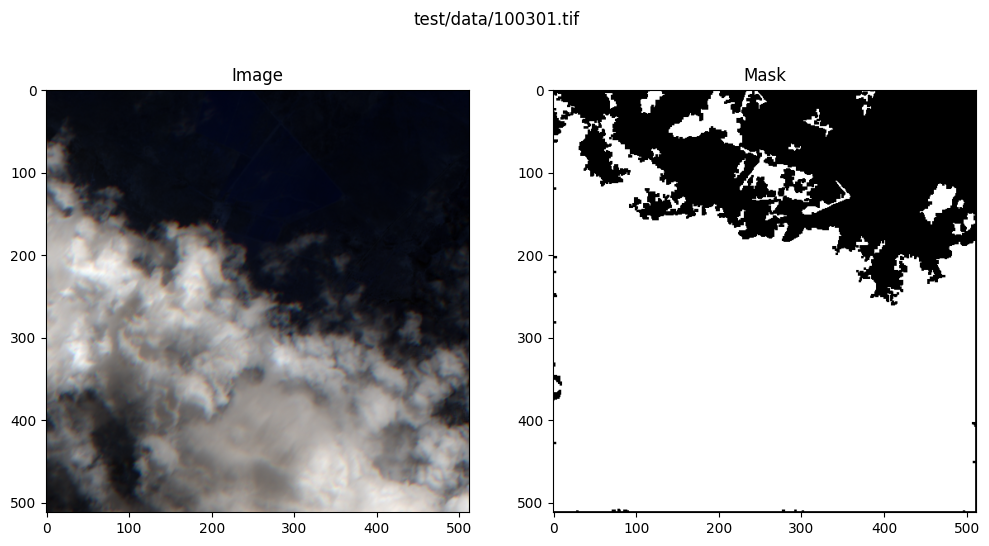

In [68]:
from visualization import plot_image_and_mask
image_path = "test/data/100193.tif"
image_path = "test/data/100096.tif"
image_path = "test/data/100177.tif"
image_path = "test/data/100205.tif"
image_path = "test/data/100301.tif"
image = load_and_normalize_tiff(image_path)
features = extract_features(image, feature_selector)
proba = model.predict_proba(features)[:, 1]
pred = (proba > 0.99999999999).astype(int)
pred = post_process_mask(pred.reshape((512,512)))
    
plot_image_and_mask(image,pred,image_path)